# 전통적 시계열 모델링

   ## 유통매장 수요량 예측

* 비즈니스 현황
    * 고객사는 A 유통회사의 a 매장 입니다.
    * a 매장에서 주력상품인 a01에 대한 재고 최적화를 위해 수요량을 예측하고자 합니다.
    * 최근 경쟁사의 매장이 가까운 거리에 오픈하였고, 유사한 상품에 대한 공격적인 마케팅을 펼치고 있습니다. 
* 발주 최적화를 위한 수요량 예측 : 1일후의 판매량을 예측

![](https://www.artefact.com//wp-content/uploads/2021/08/GettyImages-1295864156-scaled.jpg)

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성 

* 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

* 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

## (3) Data Loading

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path)
data = data.loc[(data['date']>= '2013-06-01') & (data['date']< '2015-03-01')].reset_index(drop = True)
data.head(10)

,date,item,sales,tot_sales,comp_sales
0,2013-06-01,28,124,1016,80
1,2013-06-02,28,139,1019,93
2,2013-06-03,28,77,676,65
3,2013-06-04,28,93,764,80
4,2013-06-05,28,117,818,80
5,2013-06-06,28,112,881,71
6,2013-06-07,28,127,929,81
7,2013-06-08,28,105,925,78
8,2013-06-09,28,129,998,95
9,2013-06-10,28,103,710,74


* 변수 설명

    * date : 날짜
    * item : 상품코드 (여기서는 한가지 상품만 있음)
    * sales : A유통회사 a 매장 판매량 ==> target
    * tot_sales : A유통회사 전체 판매량
    * comp_sales : 인근에 위치한 B유통회사 b 매장 판매량

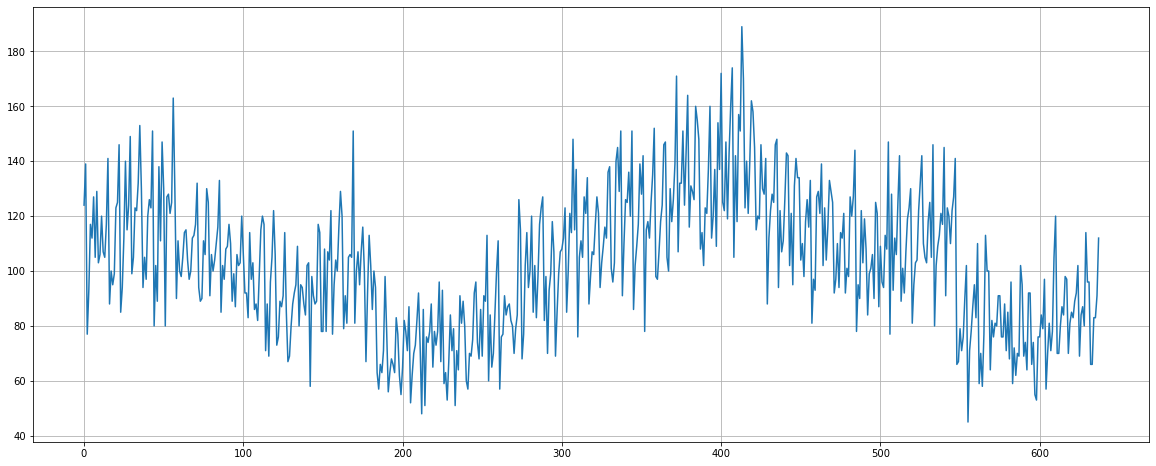

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

# 2.기본 전처리

## (1) y 만들기

* 1일 후 수요량을 예측하려면, y를 어떻게 만들어야 할까요?

In [6]:
data['y'] = data['sales'].shift(-1)
display(data.head())
display(data.tail())

,date,item,sales,tot_sales,comp_sales,y
0,2013-06-01,28,124,1016,80,139.0
1,2013-06-02,28,139,1019,93,77.0
2,2013-06-03,28,77,676,65,93.0
3,2013-06-04,28,93,764,80,117.0
4,2013-06-05,28,117,818,80,112.0


,date,item,sales,tot_sales,comp_sales,y
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,83.0
635,2015-02-26,28,83,611,48,91.0
636,2015-02-27,28,91,696,74,112.0
637,2015-02-28,28,112,774,77,NaN


In [7]:
# 제일 마지막 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,item,sales,tot_sales,comp_sales,y
632,2015-02-23,28,66,488,43,66.0
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,83.0
635,2015-02-26,28,83,611,48,91.0
636,2015-02-27,28,91,696,74,112.0


## (2) Feature Engineering
* 필요한 변수들을 도출해 봅시다.

## (3) 데이터 분할

### 1) x, y 나누기

In [9]:
target = 'y'

x = data.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

### 2) train, val 분할
* 1회 분할 : train_test_split( x, y, test_size= , shuffle = False) 
    * test_size : 소수 - 비율, 자연수 - 갯수
    * shuffle = False : 섞지 말고 데이터 끝에서 test_size 만큼 자르기
* k-fold cross validation for Time Seires : TimeSeriesSplit

In [10]:
# 여기서는 1회 분할로 진행합니다.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 30, shuffle = False)

# 3.모델링1 : ARIMA

## (1) y 값 살펴보기

* 정규성 검정(> 0.05) :  0.00746
* 정상성 검정(< 0.05) :  0.54662
* 자기상관성 확인(ACF, PACF)


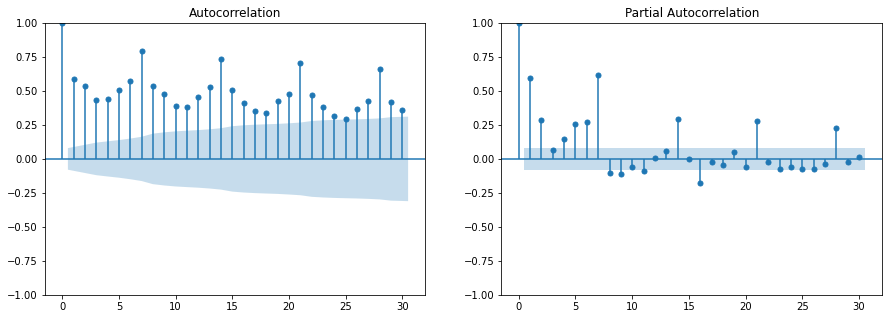

In [11]:
residual_diag(y_train, lags = 30)

## (2) 모델링 : 초기모델

* p, d, q 값을 어떻게 정해야 할까요?
* AR의 p 차수와 MA q 차수 모두 값이 필요해 보입니다. 일단 1, 1을 지정합시다.

### 1) 학습

* sm.tsa.SARIMAX(train, order=(p,d,q)).fit()
    * 모델 선언시 train이 포함
    * .fit()으로 학습.

In [14]:
model1 = sm.tsa.SARIMAX(y_train, order=(1,0,1)).fit()
model2 = sm.tsa.SARIMAX(y_train, order=(1,1,1)).fit()

### 2) 평가

#### ① 잔차진단

* 모델.resid : 잔차를 뽑을 수 있습니다.
* 위에서 만든 함수 residual_diag 를 사용하여 잔차진단을 해 봅시다.

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  1e-05
* 자기상관성 확인(ACF, PACF)


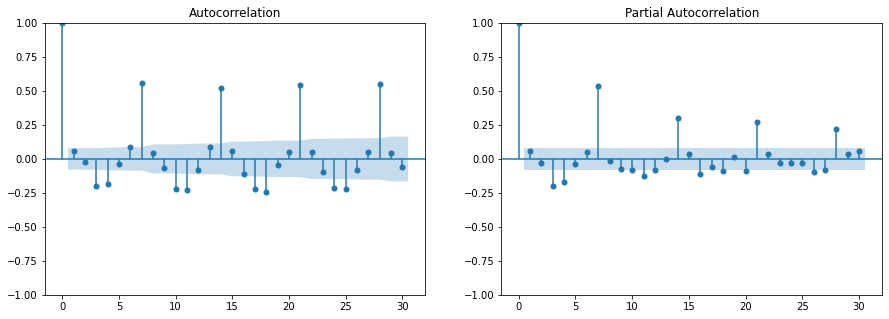

In [15]:
residuals = model1.resid # y_train과 예측값(model1.predict())과의 차이
residual_diag(residuals)

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  1e-05
* 자기상관성 확인(ACF, PACF)


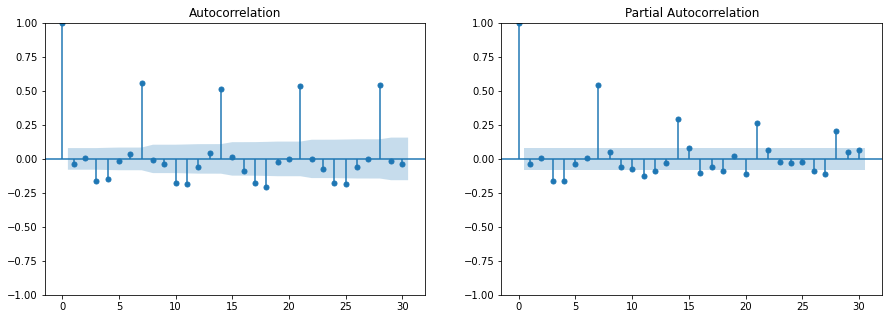

In [16]:
residuals = model2.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수
* SARIMAX 모델.aic로 쉽게 통계량을 구할 수 있습니다.

In [17]:
print('(1,0,1) aic :  ', model1.aic)
print('(1,1,1) aic :  ', model2.aic)

(1,0,1) aic :   5246.4888643518025
(1,1,1) aic :   5226.970492639293


#### ③ Validation

시계열 데이터로 실제값과 예측값에 대해 비교하여 그래프를 그려봅시다.

In [18]:
pred1 = model1.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred1))
print('MAPE:', mean_absolute_percentage_error(y_val, pred1))

MAE : 15.265834630654918
MAPE: 0.1613604162570821


In [19]:
pred2 = model2.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred2))
print('MAPE:', mean_absolute_percentage_error(y_val, pred2))

MAE : 14.898867117965457
MAPE: 0.15780557366756331


* 결과 시각화

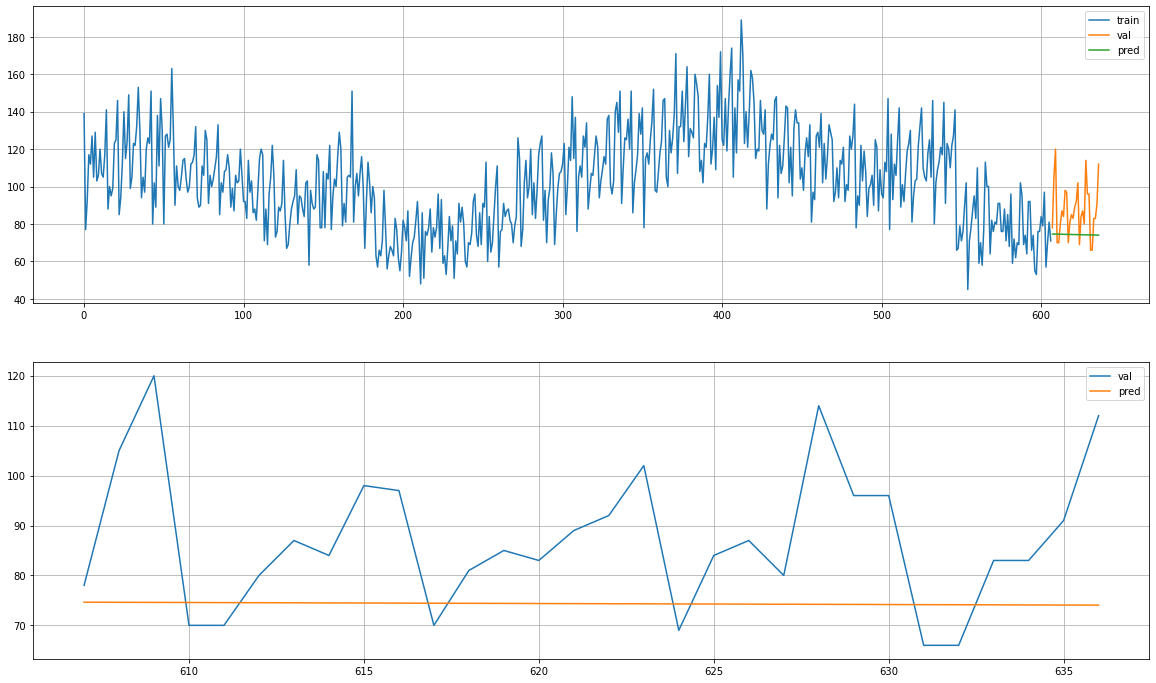

In [20]:
plot_model_result(y_train, y_val, pred1)

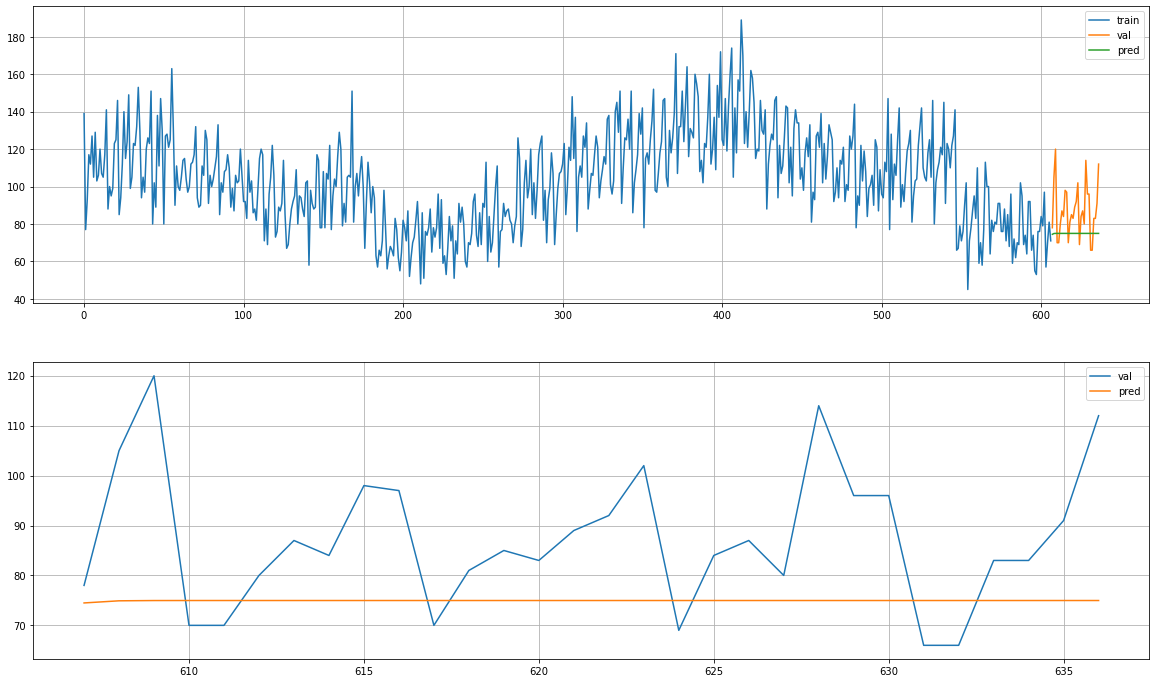

In [21]:
plot_model_result(y_train, y_val, pred2)

## (3) 하이퍼파라미터 튜닝

실제로 p, d, q를 찾는 과정은 마치 Grid Search 처럼 값을 조금씩 조정해가며  최적의 모델을 찾아가는 과정과 유사합니다.


### 1) 학습

In [22]:
from itertools import product

* 값의 범위 지정
    * 시간이 많이 소요될 수 있으니 범위를 적절하게 지정하세요.

In [23]:
# product 함수를 이용하여 값의 조합을 구성
p = list(range(1,6))
q = list(range(1,6))
d = [1,2]
iter = list(product(p,d,q))
iter

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 2, 5),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (3, 2, 5),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4),
 (4, 2, 5),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 2, 1),
 (5, 2, 2),
 (5, 2, 3),
 (5, 2, 4),
 (5, 2, 5)]

* 튜닝

In [24]:
# 
mae, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 1, 5)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(2, 1, 5)
(2, 2, 1)
(2, 2, 2)
(2, 2, 3)
(2, 2, 4)
(2, 2, 5)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(3, 1, 5)
(3, 2, 1)
(3, 2, 2)
(3, 2, 3)
(3, 2, 4)
(3, 2, 5)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)
(4, 1, 5)
(4, 2, 1)
(4, 2, 2)
(4, 2, 3)
(4, 2, 4)
(4, 2, 5)
(5, 1, 1)
(5, 1, 2)
(5, 1, 3)
(5, 1, 4)
(5, 1, 5)
(5, 2, 1)
(5, 2, 2)
(5, 2, 3)
(5, 2, 4)
(5, 2, 5)


In [25]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
41,"(5, 1, 2)",10.486904,4984.713653


,"params(p,d,q)",mae,aic
34,"(4, 1, 5)",11.748057,4930.651495


In [26]:
result

,"params(p,d,q)",mae,aic
0,"(1, 1, 1)",14.898867,5226.970493
1,"(1, 1, 2)",14.937143,5223.401599
2,"(1, 1, 3)",14.825890,5224.920910
3,"(1, 1, 4)",15.387541,5189.504549
4,"(1, 1, 5)",15.387584,5191.501507
5,"(1, 2, 1)",16.178622,5389.156974
6,"(1, 2, 2)",20.779535,5229.852247
7,"(1, 2, 3)",19.895194,5226.848783
8,"(1, 2, 4)",20.490571,5226.105617
9,"(1, 2, 5)",21.453392,5221.828721


In [33]:
# 가장 성능이 좋은 p, d, q 값으로 모델을 생성합니다.
model3 = sm.tsa.SARIMAX(y_train, order=(5,1,2)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


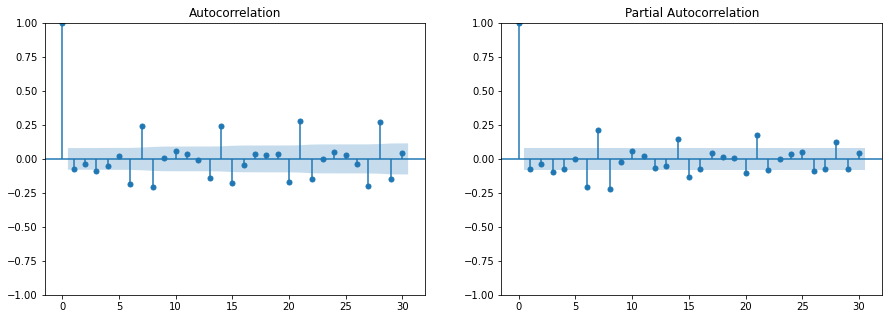

In [34]:
residuals = model3.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [35]:
print('(5,1,2) aic : ', model3.aic)

(5,1,2) aic :  4984.713652847422


#### ③ Validation

In [36]:
pred3 = model3.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred3))
print('MAPE:', mean_absolute_percentage_error(y_val, pred3))

MAE : 10.486904338488394
MAPE: 0.11286995496696649


* 결과 시각화

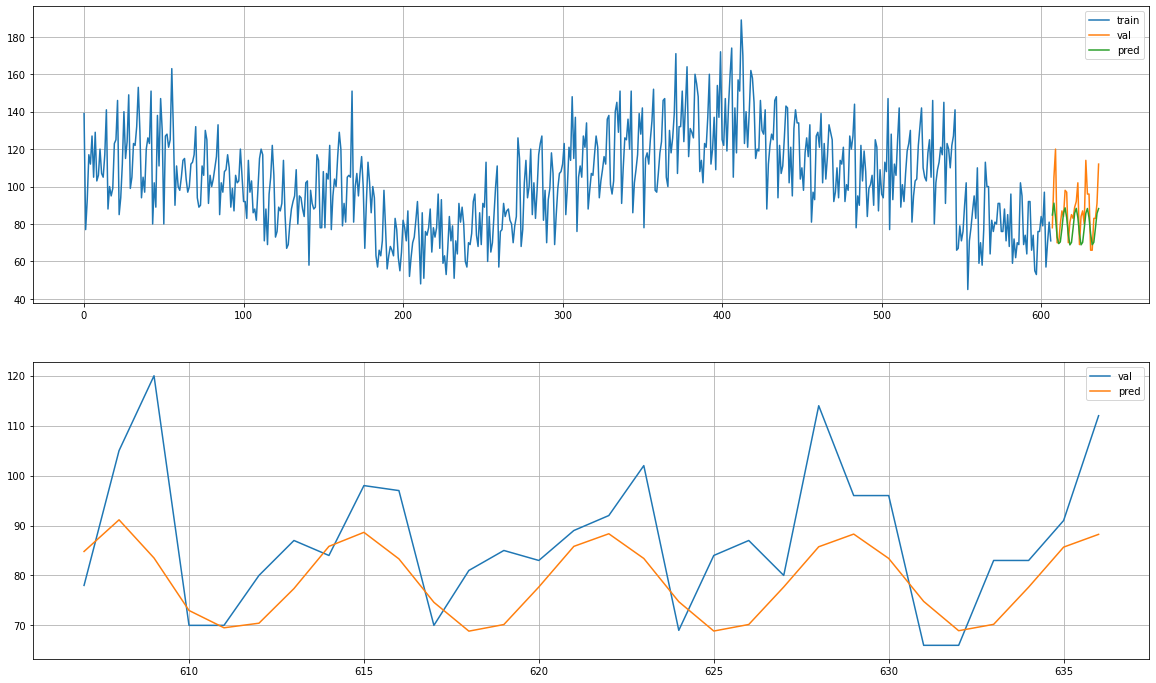

In [37]:
plot_model_result(y_train, y_val, pred3)

# 4.모델링2 : SARIMA

## (1) 모델링 : 초기모델

### 1) 학습

In [38]:
# SARIMA 모델링 : P, D, Q, m = 1,1,1,7 로 모델을 생성합시다.
model3_1 = sm.tsa.SARIMAX(y_train, order=(5,1,2), seasonal_order=(1,1,1,7)).fit()

### 2) 평가

#### ① 잔차진단

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


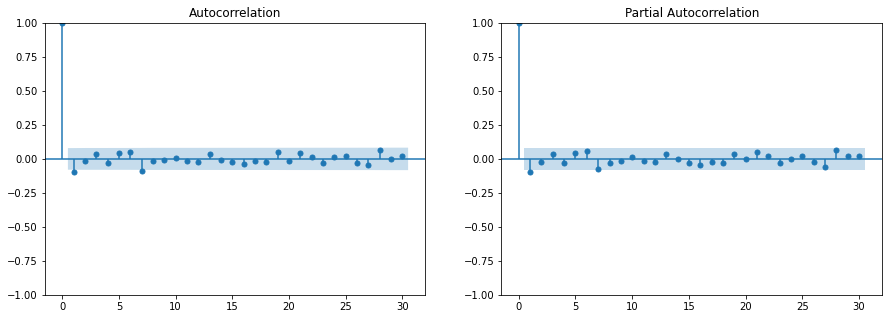

In [39]:
residuals = model3_1.resid
residual_diag(residuals)

#### ② AIC

In [40]:
model3_1.aic

4678.491587004812

#### ③ Validation

In [41]:
pred4 = model3_1.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred4))
print('MAPE:', mean_absolute_percentage_error(y_val, pred4))

MAE : 11.157809384257707
MAPE: 0.12643001580539853


* 결과 시각화

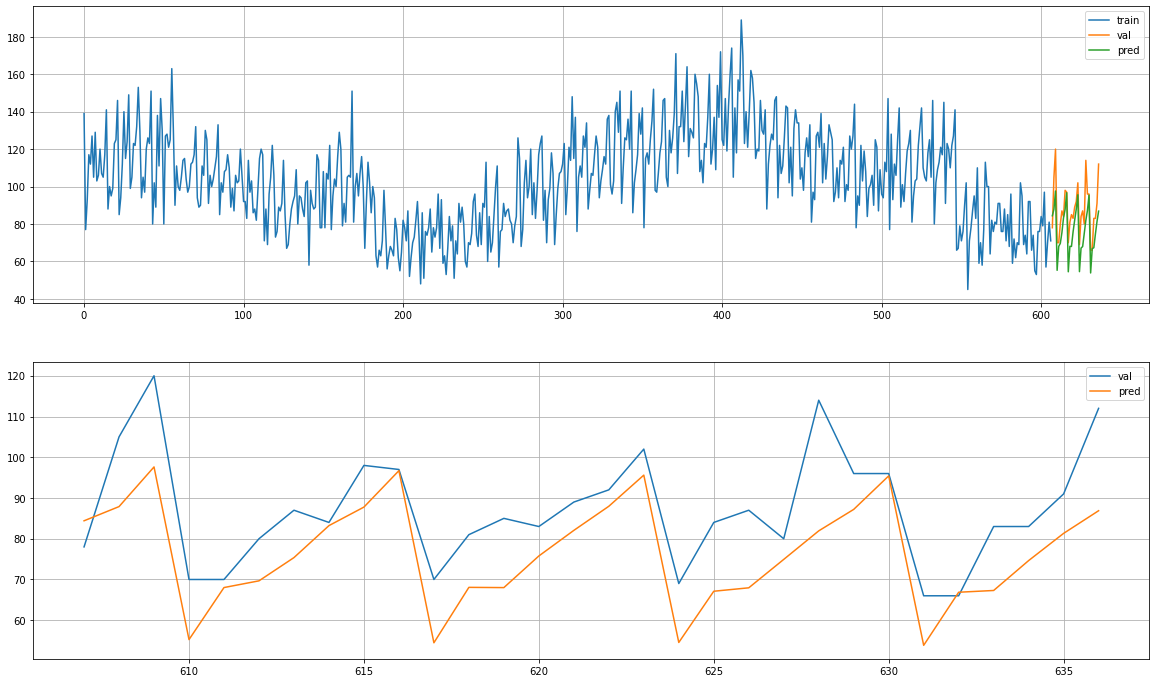

In [42]:
plot_model_result(y_train, y_val, pred4)

## (2) 하이퍼파라미터 튜닝
* 너무 큰 범위를 지정하면 시간이 많이 걸립니다.
    * D는 1로 고정
    * P, Q는 1 ~ 4 사이에서 결정

### 1) 학습

In [43]:
P = list(range(1,5))
Q = list(range(1,5))
D = [1]
mae, aic = [],[]
iter = list(product(P,D,Q))

for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(5,1,2), seasonal_order=(i[0],i[1],i[2],7)).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)


In [44]:
result = pd.DataFrame({'params(P,D,Q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(P,D,Q)",mae,aic
14,"(4, 1, 3)",10.624408,4685.341906


,"params(P,D,Q)",mae,aic
0,"(1, 1, 1)",11.157809,4678.491587


In [45]:
# 가장 성능이 좋은 P, D, Q 값으로 모델을 생성합니다.
model4_1 = sm.tsa.SARIMAX(y_train, order=(5,1,2), seasonal_order=(4,1,3,7)).fit()
model4_2 = sm.tsa.SARIMAX(y_train, order=(5,1,2), seasonal_order=(4,1,1,7)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


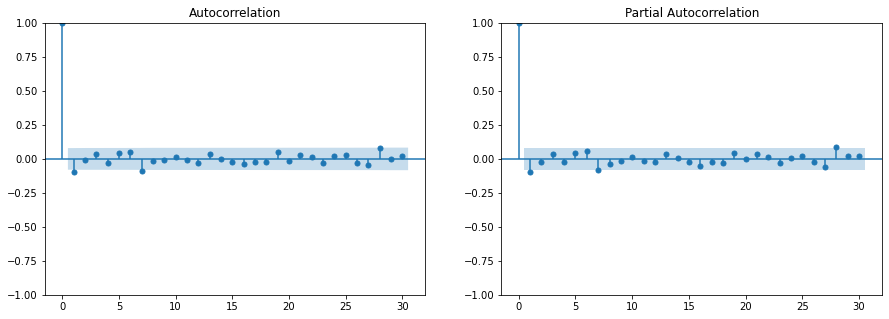

In [46]:
residuals = model4_1.resid
residual_diag(residuals)

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


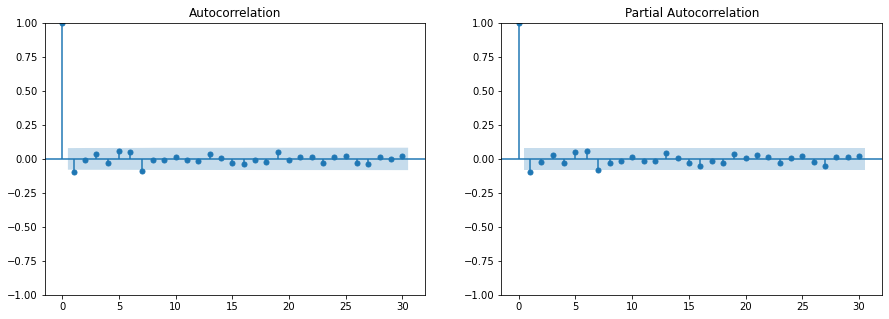

In [47]:
residuals = model4_2.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [48]:
model4_1.aic, model4_2.aic

(4685.341906407683, 4680.789827760635)

#### ③ Validation

In [49]:
pred5 = model4_2.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred5))
print('MAPE:', mean_absolute_percentage_error(y_val, pred5))

MAE : 11.407403713830876
MAPE: 0.12873342270052762


* 결과 시각화

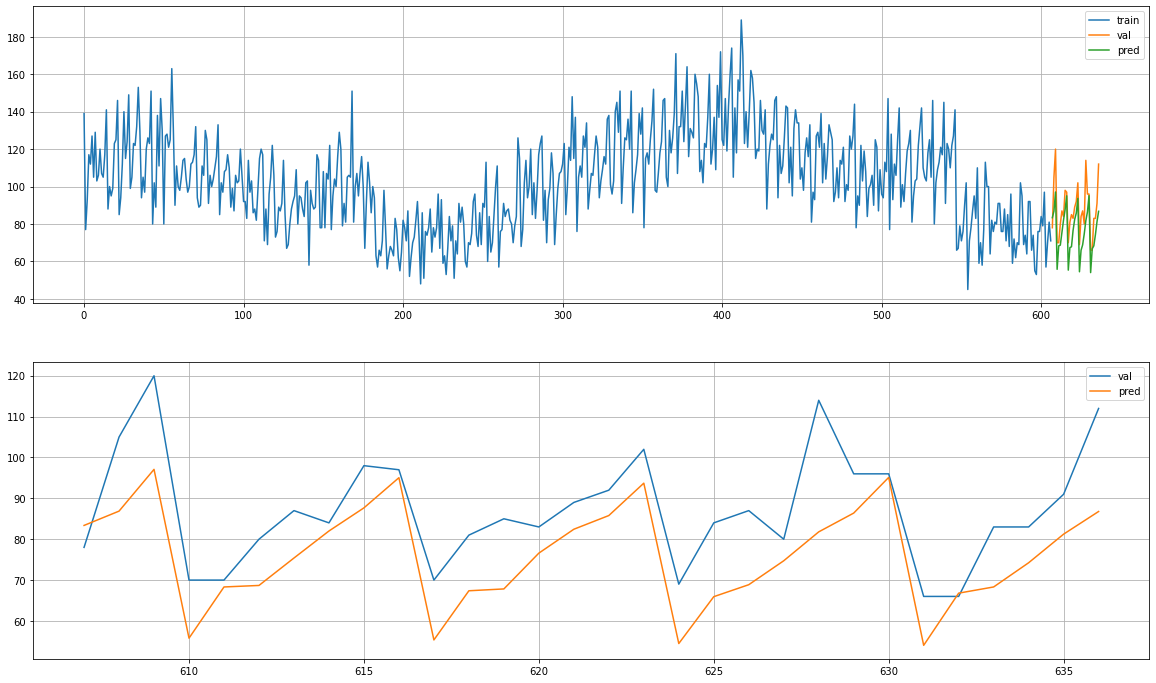

In [50]:
plot_model_result(y_train, y_val, pred5)

# 5.모델링3 : SARIMAX

## (1) 모델링

### 1) 학습
* 위에서 찾은 차수(p,d,q, P,D,Q,m) 에 x_train을 넣어 모델링해 봅시다.

In [51]:
m3_1 = sm.tsa.SARIMAX(y_train, order=(5,1,2), seasonal_order=(4,1,3,7), exog=x_train).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


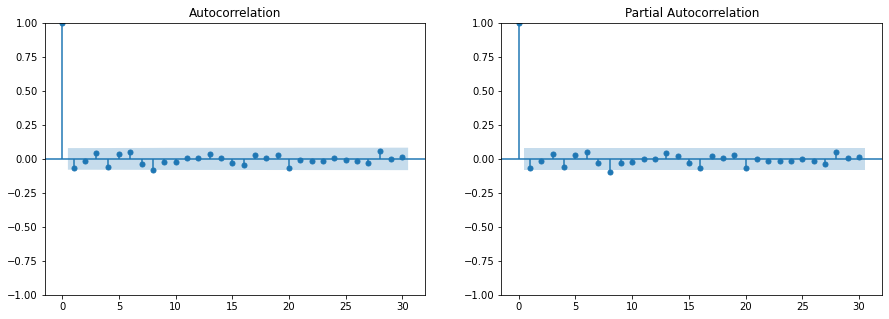

In [52]:
residuals = m3_1.resid
residual_diag(residuals)

#### ② AIC

In [53]:
print('m3_1 AIC :', m3_1.aic)

m3_1 AIC : 4640.764813785499


#### ③ Validation
SARIMAX 모델을 생성하고, 예측할 때는 exog=x_val 옵션이 들어가야 함.

In [54]:
pred = m3_1.forecast(30,  exog=x_val)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 7.898073766980521
MAPE: 0.09005807460803365


* 결과 시각화

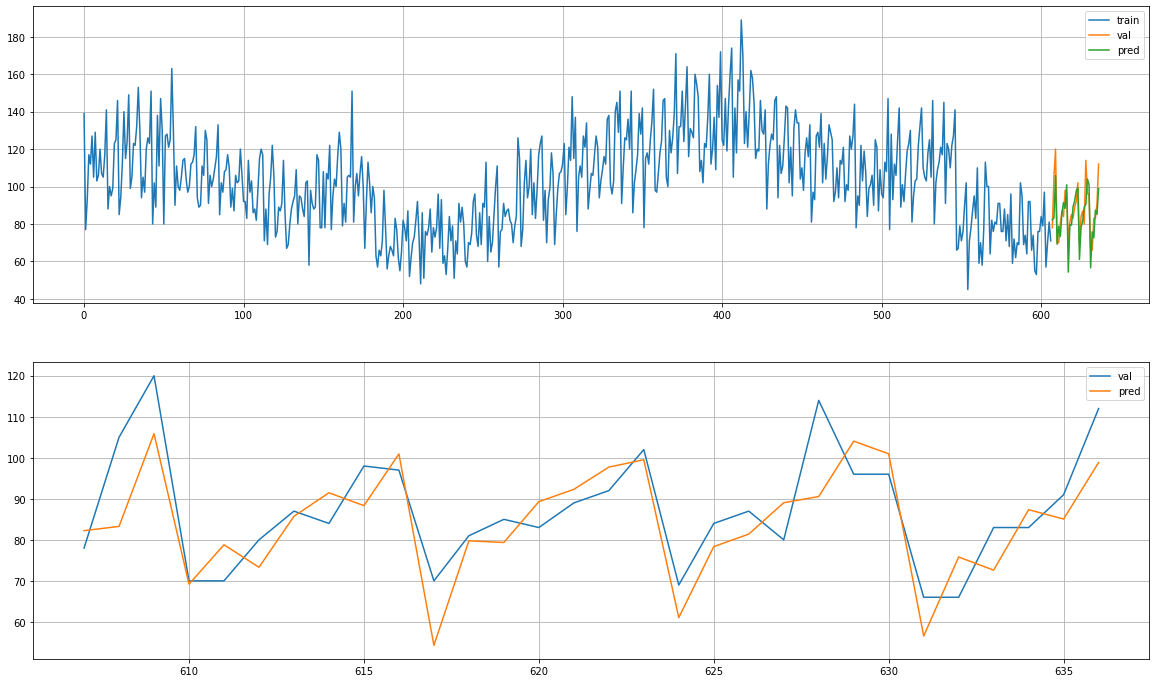

In [55]:
plot_model_result(y_train, y_val, pred)